以支付宝某次营销活动的数据为例，通过分析广告点击率，比较两组营销策略的广告投放效果

# 数据准备

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 数据描述

dmp_id：营销策略编号（源数据文档未作说明，这里根据数据情况设定为1：对照组，2：营销策略一，3：营销策略二）  
user_id：支付宝用户ID  
label：用户当天是否点击活动广告（0：未点击，1：点击）

In [2]:
data = pd.read_csv('data/effect_tb.csv')
data.columns = ["dt","user_id","label","dmp_id"]
data.head()

,dt,user_id,label,dmp_id
0,1,1000004,0,1
1,1,1000004,0,2
2,1,1000006,0,1
3,1,1000006,0,3
4,1,1000007,0,1


In [3]:
data.drop(['dt'],axis=1,inplace=True)
data.shape

(2645957, 3)

## 删除重复行   
重复的多条数据，会影响最终的计算比例，对结果造成干扰

In [4]:
data.drop_duplicates(inplace=True)
data.shape

(2632974, 3)

## 查看是否有缺失值

In [5]:
data.isnull().sum()

user_id    0
label      0
dmp_id     0
dtype: int64

## 处理重复用户  
可能存在一个用户多次点击的情况，这种情况下，多次点击的用户的用户群体的权重就会增大，导致结果出现误差。  

In [6]:
(data.user_id.value_counts() > 1).sum()

201265

## 确定样本量

计算对照组的广告点击率

In [7]:
data[data.dmp_id == 1].label.mean()

0.012551019015964006

不同营销组的样本量

In [8]:
data.dmp_id.value_counts()

1    1905662
2     411107
3     316205
Name: dmp_id, dtype: int64

# 假设检验

## 不同策略的广告点击率

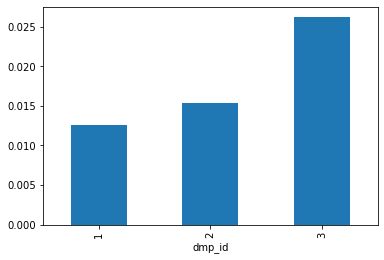

In [9]:
data.groupby(['dmp_id'])['label'].mean().plot(kind='bar')

## 假设检验

In [10]:
# 对照组样本数量
n_control = data[data.dmp_id==1].shape[0]
# 营销活动二的样本数量
n_test = data[data.dmp_id==3].shape[0]


c_control = data[(data.dmp_id==1) & (data.label==1)].shape[0]

c_test = data[(data.dmp_id==3) & (data.label==1)].shape[0]

# 对照组的广告点击率
r_control = c_control/n_control
# 营销活动二样本数量
r_test = c_test/n_test

In [11]:
from statsmodels.stats.proportion import proportions_ztest

z_score,p = proportions_ztest([c_control,c_test],[n_control,n_test])

print("检验统计量z：",z_score,"，p值：", p)

检验统计量z： -59.44164223047762 ，p值： 0.0


## 蒙特卡洛法

In [12]:
# 假设所有策略的点击率一样
p_all = data.label.mean() 

In [13]:
p_all

0.014620729259005216

### 模拟抽样

In [14]:
diff = []

for i in range(1000):
    p_new_diff = np.random.choice(2,size = n_test,p=[1-p_all,p_all]).mean()
    p_old_diff = np.random.choice(2,size = n_control,p=[1-p_all,p_all]).mean()
    diff.append(p_old_diff - p_new_diff)

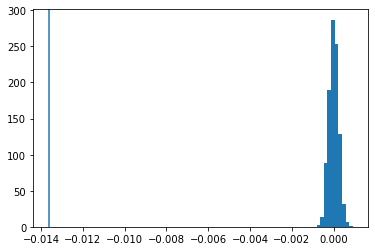

In [15]:
diffs = np.array(diff)
plt.hist(diffs)
plt.axvline(r_control-r_test)

In [16]:
(diffs < r_control-r_test).mean()

0.0

一个完整的A/B test主要包括如下几部分：

1、分析现状，建立假设：分析业务，确定最高优先级的改进点，作出假设，提出优化建议。

2、设定指标：设置主要指标来衡量版本的优劣；设置辅助指标来评估其他影响。

3、设计与开发：设计优化版本的原型并完成开发。

4、确定测试时长：确定测试进行的时长。

5、确定分流方案：确定每个测试版本的分流比例及其他分流细节。

6、采集并分析数据：收集实验数据，进行有效性和效果判断。

7、给出结论：①确定发布新版本；②调整分流比例继续测试；③优化迭代方案重新开发，回到步骤1。

注意点：
1. 测试时长：测试的时长不宜过短，否则参与试验的用户几乎都是产品的高频用户。

2. 分流（或者说抽样）：应该保证同时性、同质性、唯一性、均匀性。

①同时性：分流应该是同时的，测试的进行也应该是同时的。

②同质性：也可以说是相似性，是要求分出的用户群，在各维度的特征都相似。可以基于用户的设备特征（例如手机机型、操作系统版本号、手机语言等）和用户的其他标签（例如性别、年龄、新老用户、会员等级等）进行分群，每一个A/B测试试验都可以选定特定的用户群进行试验。

思考：如何判断是不是真的同质？可以采用AAB测试。抽出两份流量进行A版本的测试，进行AA测试，并分别与B版本进行AB测试。通过考察A1和A2组是否存在显著性差异，就可以确定试验的分流是否同质了。

③唯一性：即要求用户不被重复计入测试。

④均匀性：要求各组流量是均匀的。Hash算法。现在一般由专用的A/B测试工具负责。也有看到一篇文章写了python实现，大体的思路是对用户id添加Salt值，对其散列，并据此算出一个0-1之间的浮点数，同设定好的阈值比大小，从而分组。有兴趣的可以看看，该作者的思路很清晰： 随机分配里的Why and How。（统计学原理上，我没有找到均匀性这一要求的依据，其实双样本的假设检验并不要求两个样本的数量相等或相近。当然从直观上是可以理解，希望分出的用户组越相近越好，包括人数的相近。）